# Scenario Analysis: Profit Sensitivity

This notebook tests how profitability changes under realistic shocks and improvements: 
- marketing efficiency
- fulfilment cost inflation
- pricing changes

The objective is to identify resilient products and the best levers for sustainable growth.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/pratikchhetri/Documents/sme-d2c-analysis/data/processed/sme_d2c_processed.csv")
df.head()

,date,product,units_sold,unit_price,cogs_per_unit,fulfilment_cost_per_unit,marketing_spend,returns_rate,revenue,cogs,returns_cost,fulfilment_cost,gross_profit,net_profit,month
0,2023-01-01,Product A,85,25,13,3,341.70,0.052,2125,1105,110.50,255,1020,312.80,2023-01
1,2023-01-01,Product B,53,40,23,4,327.13,0.046,2120,1219,97.52,212,901,264.35,2023-01
2,2023-01-01,Product C,25,60,32,5,203.51,0.027,1500,800,40.50,125,700,330.99,2023-01
3,2023-01-01,Product D,19,90,48,7,209.79,0.017,1710,912,29.07,133,798,426.14,2023-01
4,2023-01-02,Product A,90,25,13,3,276.75,0.089,2250,1170,200.25,270,1080,333.00,2023-01


In [2]:
baseline = df.groupby("product")["net_profit"].sum().to_frame("Baseline Profit")
baseline

,Baseline Profit
product,
Product A,268857.665
Product B,326067.090
Product C,363556.120
Product D,403001.050


In [3]:
s1 = df.copy()
s1["returns_cost"] *= 0.95

s1["gross_profit"] = s1["revenue"] - s1["cogs"]

s1["net_profit"] = (
    s1["gross_profit"]
    - s1["fulfilment_cost"]
    - s1["returns_cost"]
    - s1["marketing_spend"]
)

s1_profit = s1.groupby("product")["net_profit"].sum().to_frame("Returns -5%")
s1_profit

,Returns -5%
product,
Product A,274358.49375
Product B,330032.42000
Product C,365322.00400
Product D,404227.61500


In [4]:
s2 = df.copy()
s2["fulfilment_cost"] *= 1.10
s2["net_profit"] = s2["gross_profit"] - s2["fulfilment_cost"] - s2["returns_cost"] - s2["marketing_spend"]

s2_profit = s2.groupby("product")["net_profit"].sum().to_frame("Fulfilment +10%")
s2_profit

,Fulfilment +10%
product,
Product A,249948.365
Product B,308538.690
Product C,351775.120
Product D,392039.050


In [5]:
s3 = df.copy()

s3.loc[s3["product"] == "Product D", "unit_price"] *= 1.05

s3["revenue"] = s3["units_sold"] * s3["unit_price"]
s3["gross_profit"] = s3["revenue"] - s3["cogs"]
s3["net_profit"] = s3["gross_profit"] - s3["fulfilment_cost"] - s3["returns_cost"] - s3["marketing_spend"]

s3_profit = s3.groupby("product")["net_profit"].sum().to_frame("Price(D) +5%")
s3_profit

,Price(D) +5%
product,
Product A,268857.665
Product B,326067.090
Product C,363556.120
Product D,473471.050


In [6]:
compare = baseline.copy()

compare["Returns -5%"] = s1_profit["Returns -5%"]
compare["Fulfilment +10%"] = s2_profit["Fulfilment +10%"]
compare["Price D +5%"] = s3_profit["Price(D) +5%"]

for col in compare.columns[1:]:
    compare[col + " (change)"] = compare[col] - compare["Baseline Profit"]

for col in compare.columns[1:4]:
    compare[col + " (% change)"] = (
        compare[col + " (change)"] / compare["Baseline Profit"]
    )

compare

,Baseline Profit,Returns -5%,Fulfilment +10%,Price D +5%,Returns -5% (change),Fulfilment +10% (change),Price D +5% (change),Returns -5% (% change),Fulfilment +10% (% change),Price D +5% (% change)
product,,,,,,,,,,
Product A,268857.665,274358.49375,249948.365,268857.665,5500.82875,-18909.3,0.0,0.020460,-0.070332,0.000000
Product B,326067.090,330032.42000,308538.690,326067.090,3965.33000,-17528.4,0.0,0.012161,-0.053757,0.000000
Product C,363556.120,365322.00400,351775.120,363556.120,1765.88400,-11781.0,0.0,0.004857,-0.032405,0.000000
Product D,403001.050,404227.61500,392039.050,473471.050,1226.56500,-10962.0,70470.0,0.003044,-0.027201,0.174863


#### "(change)" = Change values represent the difference in net profit relative to the baseline scenario.
#### "(% change)" = Percentage change from the baseline.

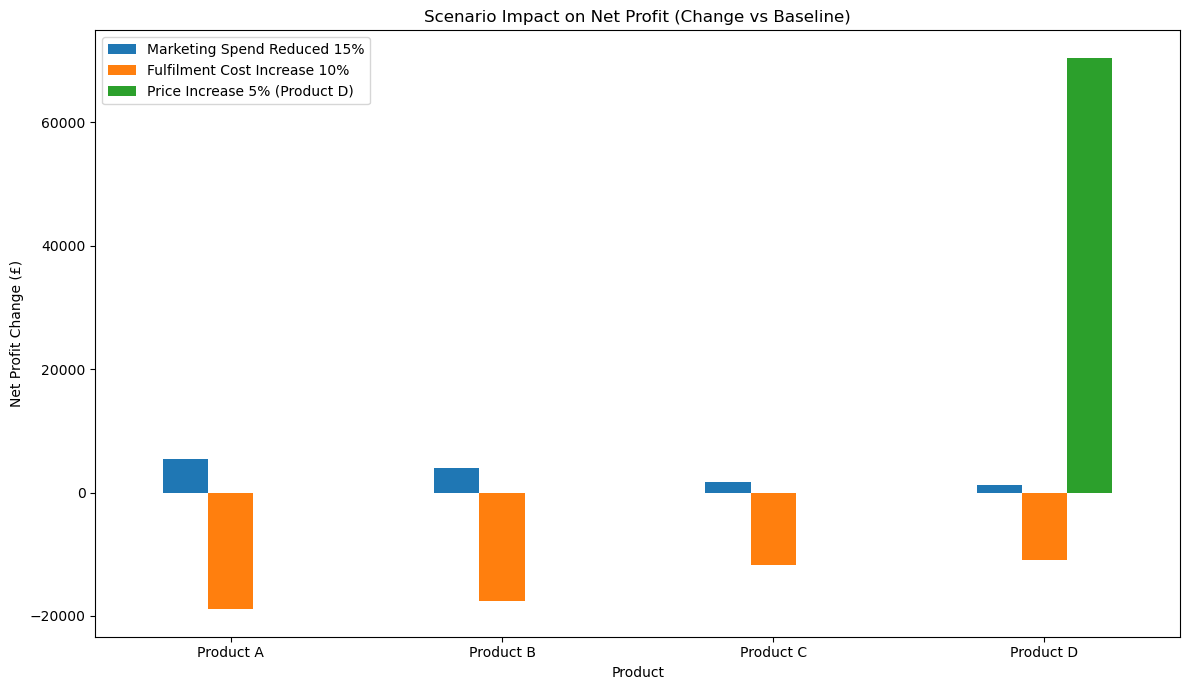

In [7]:
change_cols = [c for c in compare.columns if c.endswith(" (change)")]

fig, ax = plt.subplots(figsize=(12,7))

compare[change_cols].plot(kind="bar", ax=ax)

ax.set_title("Scenario Impact on Net Profit (Change vs Baseline)")
ax.set_xlabel("Product")
ax.set_ylabel("Net Profit Change (£)")

plt.xticks(rotation=0)

plt.legend([
    "Marketing Spend Reduced 15%",
    "Fulfilment Cost Increase 10%",
    "Price Increase 5% (Product D)"
])

plt.tight_layout()
plt.show()

## Management Implications

- Marketing efficiency improvements deliver the biggest uplift for products with high marketing intensity.
- Fulfilment cost inflation disproportionately harms lower-margin or high-volume products.
- Premium pricing power (Product D) provides a direct profit uplift, suggesting pricing is a strong lever if demand holds.

Recommendation: prioritise resilient products for scaling and set guardrails (e.g., minimum profit thresholds) before increasing spend.
